# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part1 MNIST data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a digit(MNIST data) given its label. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load MNIST datasets
The MNIST datasets will be downloaded into the 'data' directory. If you want to change the directory the data is saved in, change mnist_data_dir with where you want. <br>

In [1]:
from download import *
import os
from utils import load_mnist
mnist_data_dir = './data'
prepare_data_dir(mnist_data_dir)
download_mnist(mnist_data_dir)
data_array , data_y = load_mnist(os.path.join(mnist_data_dir,'mnist'))
print(data_array.shape)
print(data_y.shape)

Found MNIST - skip
(70000, 28, 28, 1)
(70000, 10)


## <a name="1"></a> 1. Building a network

In this section, you will implement neural networks for (1) generative model to draw a digit (2) discriminative model to distinguish real image from generated image. You can use some function in *ops.py* or you can make it as you want. Just write the code in whatever way you find most clear.

In [2]:
from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

It is time for a generative model. It takes batch size, sample size(the dimension of latent variable or so called *noise*), y_dim(the dimension of label), the output size(should be 28 here) and z,y (Tensorflow Variables for latent variable and label respectively). It should return the image 28x28 output of which each element is in [0,1]. Note that you should define Tensorflow Variables within the variable scope.

You should utilize the label variable y in your model. The simplest way is concatenate the label variable and features or raw image.

In [3]:

def gern_net(batch_size, z , y , sample_size, y_dim, output_size): # z : noise, y : label
    with tf.variable_scope('gen'):
        #### TODO  ####
        # concat z,y(one-hot encoding => y_dim = 10)
        z_y = tf.concat([z,y],1) # (?,110)
        initializer = tf.contrib.layers.xavier_initializer()
        layer_1 = tf.nn.relu(batch_normal(tf.layers.dense(z_y,1024,kernel_initializer=initializer,name="l1"),scope="layer1"))
        layer_2 = tf.nn.relu(batch_normal(tf.layers.dense(layer_1,512,kernel_initializer=initializer,name="l2"),scope="layer2"))
        layer_3 = tf.nn.relu(batch_normal(tf.layers.dense(layer_2,512,kernel_initializer=initializer,name="l3"),scope="layer3"))
        layer_4 = tf.nn.tanh(tf.layers.dense(layer_3,output_size*output_size,kernel_initializer=initializer,name="l7"))
        
        output = tf.reshape(layer_4,[batch_size,output_size,output_size,1])
        
        return output
       
    ####TODO ####


Now, it's time for a discriminative model. It takes image data and label variable y. It should return the value for which the model is certain that the image is real and its logit. (i.e return the value in [0,1] and its logit). Note that you should define Tensorflow Variables within the variable scope again.

You may use the label variable or not. Here, again concatenating is the simplest way to utilize it.

In [4]:
def dis_net(image_data , y, reuse=False):
    with tf.variable_scope('dis',reuse=reuse):
        
        #### TODO ####
        batch_data = tf.reshape(image_data,[128,28*28])
        image_y = tf.concat([batch_data,y],1)
        image_y = image_y + tf.random_normal(shape=tf.shape(image_y), mean=0.0, stddev=0.01, dtype=tf.float32)

        initializer = tf.contrib.layers.xavier_initializer()

        layer_1 = lrelu((tf.layers.dense(image_y,1024,kernel_initializer=initializer,name="l7")))
        layer_2 = lrelu((tf.layers.dense(layer_1,512,kernel_initializer=initializer,name="l8")))
        layer_3 = lrelu((tf.layers.dense(layer_2,256,kernel_initializer=initializer,name="l9")))
        
        logits = tf.layers.dense(layer_3,1,kernel_initializer=initializer)
        prob = tf.nn.sigmoid(logits)
        return prob,logits
    #### TODO ####


## <a name="2"></a> 2. Build a main part and train

In this section, you will implement the main part. You should define the loss function for each model(TODO part). Then run the code and check the model draws a digit for given label.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

Also, you can change all other hyperparameters such as learning rate, batch size. But be sure to define **batch size bigger than 100**.

In [5]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

learning_rate = 0.0002
batch_size = 128
EPOCH = 150
loss_step    = 500
display_step = 50
sample_size = 100
y_dim = 10
channel = 1
output_size = 28
sample_dir = 'samples_for_test'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Define the loss function in the TODO part. Modify only loss part.

Discriminator loss : log[D(x)] + log[1-D(G(z))]
Generator loss     : log[D(G(z)]

If you write the code correctly and run the code, it will display 10x10 images(each row shows one of the number). 

Also, it will save the generated images in the 'sample_dir' directory. So if you want to see it, check that directory.

**Please be sure that you ran the above codes**.

EPOCH 0 step 500: D: loss = 1.6405993 G: loss=2.4173641 


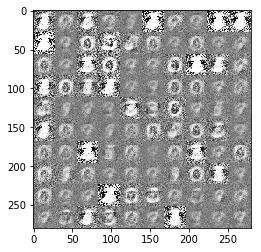

EPOCH 1 step 1000: D: loss = 1.4109037 G: loss=4.2253599 
EPOCH 2 step 1500: D: loss = 1.6048871 G: loss=1.8748755 
EPOCH 3 step 2000: D: loss = 1.3696861 G: loss=2.0906677 
EPOCH 4 step 2500: D: loss = 1.4484611 G: loss=4.7195930 
EPOCH 5 step 3000: D: loss = 1.4769509 G: loss=1.5612192 
EPOCH 6 step 3500: D: loss = 1.3744056 G: loss=2.7840328 
EPOCH 7 step 4000: D: loss = 1.5115969 G: loss=1.6372705 
EPOCH 8 step 4500: D: loss = 1.2423310 G: loss=3.8500767 
EPOCH 9 step 5000: D: loss = 1.3924712 G: loss=2.0760283 
EPOCH 10 step 5500: D: loss = 1.3300128 G: loss=2.5005038 
EPOCH 10 step 6000: D: loss = 1.1961942 G: loss=3.9838839 
EPOCH 11 step 6500: D: loss = 1.7247268 G: loss=2.2732673 
EPOCH 12 step 7000: D: loss = 1.2164468 G: loss=3.3542631 
EPOCH 13 step 7500: D: loss = 1.2870563 G: loss=2.7564998 
EPOCH 14 step 8000: D: loss = 1.1680449 G: loss=3.2964222 
EPOCH 15 step 8500: D: loss = 1.1522371 G: loss=3.9739435 
EPOCH 16 step 9000: D: loss = 1.2032094 G: loss=2.9142478 
EPOCH 

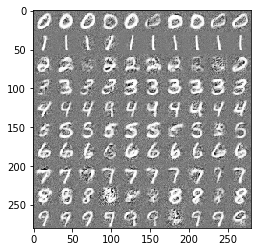

EPOCH 21 step 11500: D: loss = 1.1575977 G: loss=3.0163798 
EPOCH 21 step 12000: D: loss = 1.1822923 G: loss=3.1160836 
EPOCH 22 step 12500: D: loss = 1.1627071 G: loss=4.1518674 
EPOCH 23 step 13000: D: loss = 1.2726666 G: loss=3.1222701 
EPOCH 24 step 13500: D: loss = 1.1227144 G: loss=3.2289629 
EPOCH 25 step 14000: D: loss = 1.6017710 G: loss=6.7501326 
EPOCH 26 step 14500: D: loss = 1.1497405 G: loss=3.6871741 
EPOCH 27 step 15000: D: loss = 1.3093989 G: loss=2.4188528 
EPOCH 28 step 15500: D: loss = 1.3245872 G: loss=2.4496746 
EPOCH 29 step 16000: D: loss = 1.1477739 G: loss=3.1685061 
EPOCH 30 step 16500: D: loss = 1.2311859 G: loss=5.6840124 
EPOCH 31 step 17000: D: loss = 1.3105242 G: loss=2.6476264 
EPOCH 32 step 17500: D: loss = 1.1842411 G: loss=3.1488230 
EPOCH 32 step 18000: D: loss = 1.1547675 G: loss=3.7048204 
EPOCH 33 step 18500: D: loss = 1.1578811 G: loss=3.8306696 
EPOCH 34 step 19000: D: loss = 1.4563913 G: loss=1.7621795 
EPOCH 35 step 19500: D: loss = 1.4639380

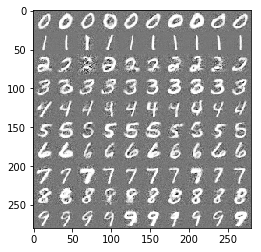

EPOCH 41 step 22500: D: loss = 1.2205338 G: loss=3.8151956 
EPOCH 42 step 23000: D: loss = 1.2573152 G: loss=3.8155169 
EPOCH 43 step 23500: D: loss = 1.4373035 G: loss=2.1598053 
EPOCH 43 step 24000: D: loss = 1.4304976 G: loss=1.9890995 
EPOCH 44 step 24500: D: loss = 1.1970274 G: loss=3.1864157 
EPOCH 45 step 25000: D: loss = 1.4440801 G: loss=3.0198519 
EPOCH 46 step 25500: D: loss = 1.2935996 G: loss=3.7787156 
EPOCH 47 step 26000: D: loss = 1.4158782 G: loss=1.9876066 
EPOCH 48 step 26500: D: loss = 1.2077526 G: loss=3.0672541 
EPOCH 49 step 27000: D: loss = 1.3875723 G: loss=2.1646333 
EPOCH 50 step 27500: D: loss = 1.3054005 G: loss=2.3896189 
EPOCH 51 step 28000: D: loss = 1.3942136 G: loss=4.0182037 
EPOCH 52 step 28500: D: loss = 1.1859964 G: loss=3.7053730 
EPOCH 53 step 29000: D: loss = 1.2582624 G: loss=2.7460990 
EPOCH 54 step 29500: D: loss = 1.3013484 G: loss=2.6306767 
EPOCH 54 step 30000: D: loss = 1.2711765 G: loss=3.6251674 
EPOCH 55 step 30500: D: loss = 1.2818236

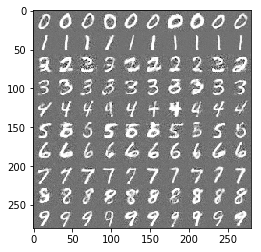

EPOCH 61 step 33500: D: loss = 1.2001631 G: loss=2.9179630 
EPOCH 62 step 34000: D: loss = 1.2381005 G: loss=2.9451835 
EPOCH 63 step 34500: D: loss = 1.5241917 G: loss=1.4618093 
EPOCH 64 step 35000: D: loss = 1.2822102 G: loss=2.3527656 
EPOCH 65 step 35500: D: loss = 1.2608993 G: loss=2.6178782 
EPOCH 65 step 36000: D: loss = 1.4227244 G: loss=1.9059937 
EPOCH 66 step 36500: D: loss = 1.2985368 G: loss=2.4265103 
EPOCH 67 step 37000: D: loss = 1.3122413 G: loss=2.4428437 
EPOCH 68 step 37500: D: loss = 1.3117894 G: loss=3.5214741 
EPOCH 69 step 38000: D: loss = 1.3148789 G: loss=2.2438362 
EPOCH 70 step 38500: D: loss = 1.2676389 G: loss=3.1274850 
EPOCH 71 step 39000: D: loss = 1.3310345 G: loss=2.5989819 
EPOCH 72 step 39500: D: loss = 1.3219867 G: loss=3.2332840 
EPOCH 73 step 40000: D: loss = 1.6874394 G: loss=1.3231529 
EPOCH 74 step 40500: D: loss = 1.3310022 G: loss=2.8978906 
EPOCH 75 step 41000: D: loss = 1.3468893 G: loss=2.2844286 
EPOCH 76 step 41500: D: loss = 1.3636637

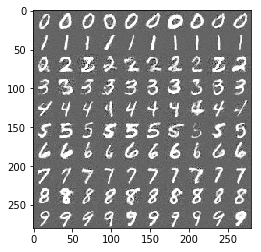

EPOCH 81 step 44500: D: loss = 1.3581191 G: loss=2.0753055 
EPOCH 82 step 45000: D: loss = 1.3235698 G: loss=2.7492809 
EPOCH 83 step 45500: D: loss = 1.4330540 G: loss=1.8802392 
EPOCH 84 step 46000: D: loss = 1.4311284 G: loss=2.9019580 
EPOCH 85 step 46500: D: loss = 1.4694189 G: loss=1.8465545 
EPOCH 86 step 47000: D: loss = 1.5406084 G: loss=1.4907281 
EPOCH 86 step 47500: D: loss = 1.3936099 G: loss=2.5799432 
EPOCH 87 step 48000: D: loss = 1.4642658 G: loss=1.6537653 
EPOCH 88 step 48500: D: loss = 1.3505840 G: loss=2.3425994 
EPOCH 89 step 49000: D: loss = 1.3512138 G: loss=2.3385677 
EPOCH 90 step 49500: D: loss = 1.3023998 G: loss=2.4807169 
EPOCH 91 step 50000: D: loss = 1.3793736 G: loss=2.1839118 
EPOCH 92 step 50500: D: loss = 1.3140984 G: loss=2.3910813 
EPOCH 93 step 51000: D: loss = 1.4197345 G: loss=2.2273412 
EPOCH 94 step 51500: D: loss = 1.3439683 G: loss=2.3517928 
EPOCH 95 step 52000: D: loss = 1.4216635 G: loss=2.1503205 
EPOCH 96 step 52500: D: loss = 1.4889243

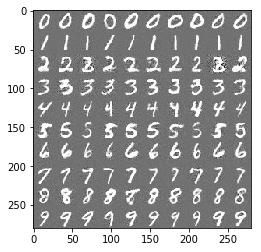

EPOCH 101 step 55500: D: loss = 1.4390267 G: loss=1.6667151 
EPOCH 102 step 56000: D: loss = 1.7090131 G: loss=1.2500329 
EPOCH 103 step 56500: D: loss = 1.3457589 G: loss=2.4354329 
EPOCH 104 step 57000: D: loss = 1.3240556 G: loss=3.0250089 
EPOCH 105 step 57500: D: loss = 1.3223197 G: loss=2.3468957 
EPOCH 106 step 58000: D: loss = 1.3921939 G: loss=2.6014638 
EPOCH 107 step 58500: D: loss = 1.4327136 G: loss=2.0291708 
EPOCH 108 step 59000: D: loss = 1.3471140 G: loss=2.2315149 
EPOCH 108 step 59500: D: loss = 1.3922058 G: loss=2.1918054 
EPOCH 109 step 60000: D: loss = 1.3590741 G: loss=2.8133688 
EPOCH 110 step 60500: D: loss = 1.5197735 G: loss=3.5667670 
EPOCH 111 step 61000: D: loss = 1.3675756 G: loss=2.4117942 
EPOCH 112 step 61500: D: loss = 1.4410284 G: loss=2.2158086 
EPOCH 113 step 62000: D: loss = 1.3687015 G: loss=2.4364460 
EPOCH 114 step 62500: D: loss = 1.4176990 G: loss=2.5456729 
EPOCH 115 step 63000: D: loss = 1.4294173 G: loss=1.9752226 
EPOCH 116 step 63500: D:

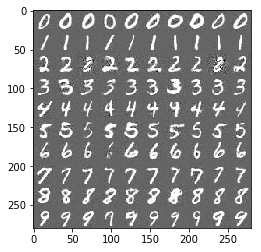

EPOCH 121 step 66500: D: loss = 1.3996055 G: loss=1.9200745 
EPOCH 122 step 67000: D: loss = 1.3629904 G: loss=2.4678309 
EPOCH 123 step 67500: D: loss = 1.3909647 G: loss=2.1992631 
EPOCH 124 step 68000: D: loss = 1.3722740 G: loss=1.9607008 
EPOCH 125 step 68500: D: loss = 1.3746738 G: loss=2.9932430 
EPOCH 126 step 69000: D: loss = 1.3540788 G: loss=3.2645636 
EPOCH 127 step 69500: D: loss = 1.5546118 G: loss=1.6771104 
EPOCH 128 step 70000: D: loss = 1.4068756 G: loss=2.1454916 
EPOCH 129 step 70500: D: loss = 1.4848933 G: loss=1.8894830 
EPOCH 130 step 71000: D: loss = 1.3321871 G: loss=2.5537891 
EPOCH 130 step 71500: D: loss = 1.4102405 G: loss=1.8648911 
EPOCH 131 step 72000: D: loss = 1.3490379 G: loss=3.1260285 
EPOCH 132 step 72500: D: loss = 1.4155294 G: loss=2.1431427 
EPOCH 133 step 73000: D: loss = 1.6015885 G: loss=3.8450422 
EPOCH 134 step 73500: D: loss = 1.3274060 G: loss=2.7002485 
EPOCH 135 step 74000: D: loss = 1.4137932 G: loss=1.9284228 
EPOCH 136 step 74500: D:

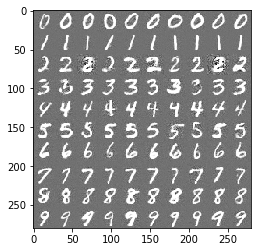

EPOCH 141 step 77000: D: loss = 1.3374239 G: loss=2.4065819 
EPOCH 141 step 77500: D: loss = 1.3165334 G: loss=2.4999270 
EPOCH 142 step 78000: D: loss = 1.2802070 G: loss=2.4451704 
EPOCH 143 step 78500: D: loss = 1.3647518 G: loss=2.3766034 
EPOCH 144 step 79000: D: loss = 1.3534746 G: loss=2.2634811 
EPOCH 145 step 79500: D: loss = 1.3777634 G: loss=2.0880923 
EPOCH 146 step 80000: D: loss = 1.4979959 G: loss=2.1367364 
EPOCH 147 step 80500: D: loss = 1.3796679 G: loss=2.4046690 
EPOCH 148 step 81000: D: loss = 1.3728883 G: loss=2.0877361 
EPOCH 149 step 81500: D: loss = 1.4085321 G: loss=3.3805060 
EPOCH 150 step 82000: D: loss = 1.3306603 G: loss=3.4116259 


In [6]:
sample_z = np.random.uniform(-1 , 1 , size = [batch_size , sample_size])

y = tf.placeholder(tf.float32, [None , y_dim])

images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])

z = tf.placeholder(tf.float32, [None , sample_size])

fake_images = gern_net(batch_size, z , y ,sample_size, y_dim,output_size)

##the loss of gerenate network
D_pro , D_logits = dis_net(images, y ,  False)

G_pro, G_logits = dis_net(fake_images , y , True)

#### TODO ####
# DEFINE LOSS FUNCTION 
D_loss_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits,labels=tf.ones_like(D_pro)))
D_loss_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits,labels=tf.zeros_like(G_pro)))

D_loss = D_loss_1 + D_loss_2 + 1
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits,labels=tf.ones_like(G_pro)))


#############

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0

    while e <= EPOCH:
        batch_num = 0
        while batch_num < len(data_array) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(data_array , data_y , batch_num, batch_size)
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels})

            batch_num += 1

            if step % loss_step == 0:

                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z , y:real_labels})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))

            if np.mod(step , display_step) == 1:

                sample_images = sess.run(fake_images , feed_dict={z:sample_z , y:sample_label(batch_size)})
                sample_images = sample_images[:100,:,:,:]
                image_name = './{}/train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
                save_images(sample_images , [10,10] , image_name)
        if e % 20 == 0:
            img = mpimg.imread(image_name)
            imgplot = plt.imshow(img)
            plt.show()

        e = e + 1
        batch_num = 0
